<style>

h1 {
    color: #fff;
    text-align: center;
    font-size: 80px;
    margin-bottom: 40px;
    margin-top: 60px;
}


p {
    color:#fff;
    font-size: 24px;
    text-align: center;
    margin-bottom: 10px;
}

.details {
    border: 2px solid #fff;
    padding: 20px;
    border-radius: 60px;
    margin: auto;
    max-width: 600px;
    margin-bottom: 30px;
}
</style>

<h1>Customer Churn</h1>

<div class="details">
    <p><strong>Integrantes:</strong> Brayan Garzón, Kevin Güiza, Julian Páez</p>
    <p><strong>Curso:</strong> Machine Learning UIFCE</p>
    <p><strong>Fecha:</strong> Julio de 2023</p>
</div>

# Modelo para Customer Churn

In [1]:
# Importar paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sys

sys.path.append("..")
from utility import plot_settings


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Machine Learning
## Preprocesamiento
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

## Entrenamiento
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
# Carga de datos
data = pd.read_csv('../data/Customer_Churn.csv', sep=';')

In [4]:
# Eliminamos la variable que no aporta información relevante (identificador de cliente)
df = data.copy()
df.drop(columns='CustomerID', inplace=True)

In [6]:
data = data.dropna()

In [7]:
data.shape

(440832, 11)

## 1. Preprocesamiento

- **Tipo de datos de cada variable:**
    - Float64: Age, Usage Frequency, Support Calls, Payment Delay, Total Spend, Last Interaction, Churn.
    - Object: Gender, Subscription Type, Contract Length.

  Podría considerarse la posibilidad de tratar a Support Calls como una variable categórica. Sin embargo, esto generaría al menos 9 variables nuevas, y podría considerarse que esto afecta la parsimonía del modelo. Así, la única variable numérica en realidad categórica es la variable objetivo (que ya está codificada)

### 1.1. Estandarización

In [8]:
numeric_cols = ['Age','Usage Frequency','Support Calls','Payment Delay','Total Spend', 'Last Interaction']

data_num = data[numeric_cols]
data_num.shape

(440832, 6)

In [9]:
# Crear instancia StandardScaler
scaler = StandardScaler()

# Estandarizar las variables
X_scaled = scaler.fit_transform(data_num)

# Dimensiones de los datos estandarizados
X_scaled.shape

(440832, 6)

La conservación de las dimensiones nos demuestra que el proceso de escalamiento no afectó la dimensión del dataset. Para tal proceso se utilizó el standard scaler [¿este escalador es el más apropiado para los datos?]

### 1.2. Codificación

In [10]:
cat_cols = ['Gender', 'Subscription Type', 'Contract Length']

data_cat = data[cat_cols]
data_cat.shape

(440832, 3)

In [11]:
# Codificación
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_encoded = encoder.fit_transform(data_cat)

# Cantidad de características generadas
X_encoded.shape

(440832, 5)

In [12]:
# Características categóricas codificadas
encoder.get_feature_names_out()

array(['Gender_Male', 'Subscription Type_Premium',
       'Subscription Type_Standard', 'Contract Length_Monthly',
       'Contract Length_Quarterly'], dtype=object)

El codificador generó 2 categorías adicionales para tipo de suscripción y duración de contrato.

### 1.3. Concatenación

In [13]:
# Características a modelar
X = np.concatenate((X_scaled, X_encoded), axis=1)
X.shape

(440832, 11)

In [14]:
# Conservar nombres de las características
feature_names = numeric_cols\
                + encoder.get_feature_names_out()\
                         .tolist()

### 1.4. Serie objetivo

In [15]:
encoder_y = OneHotEncoder(sparse_output=False, drop='if_binary')
y = encoder_y.fit_transform(data['Churn'].values.reshape(-1, 1))

y

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

### 1.5. Partición

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=31415)

### 1.6. Balanceo

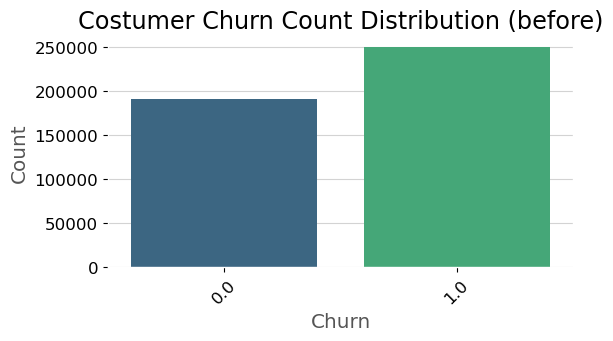

In [17]:
# Graficar antes
plt.figure(figsize=(6, 3))
sns.countplot(data=df, x='Churn', palette='viridis')
plt.title('Costumer Churn Count Distribution (before)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [18]:
# Balanceo con sobremuestreo SMOTE
smote = SMOTE(k_neighbors=5, random_state=42)
X_train_balance, y_train_balance = smote.fit_resample(X_train, y_train)

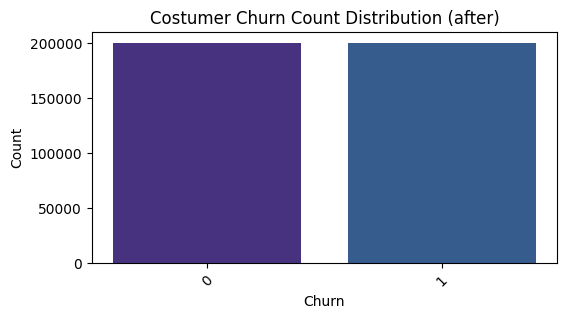

In [51]:
# Graficar luego
class_counts = pd.Series(y_train_balance).value_counts()

plt.figure(figsize=(6, 3))
plt.bar(class_counts.index, class_counts, color=sns.color_palette('viridis'))
plt.xticks(range(2))
plt.title('Costumer Churn Count Distribution (after)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## 2. Entrenamiento

### 2.1. Algoritmos a utilizar
1. Máquina de soporte vectorial (Radial Basis Function)
2. K-Nearest Neighbourgs
3. Árbol de decisión

### 2.2. Búsqueda de parámetros y validación cruzada
¿Por qué decidió usar la técnica que escogió?

In [59]:
# Definir una malla de hiperparámetros
knn_grid = {'n_neighbors':range(4, 6)}

# Establecer el GS-CV
knn_gs_cv = GridSearchCV(KNeighborsClassifier(),
                         param_grid=knn_grid,
                         cv=5,
                         verbose=1,
                         scoring='recall',
                         return_train_score=True)
                         
knn_gs_cv.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(4, 6)}, return_train_score=True,
             scoring='recall', verbose=1)

### 2.3. Elección de mejores modelos

## 3. Prueba

### 3.1. Predicciones

### 3.2. Matrices de confusión

### 3.3. Reportes de clasificación (entrenamiento y prueba)

### 3.4. AUC-ROC

## 4. Interpretación de resultados

### 4.1. Clase a predecir

### 4.2. Métrica de interés para desempeño

### 4.3. Mejor modelo